# Nicher

## Initialise Nicher

### Load packages

In [1]:
%matplotlib inline
%load_ext autoreload

import os
import sys
import gdal
import pandas as pd
import numpy as np
import xarray as xr
import datacube
import matplotlib.pyplot as plt

sys.path.append('../../../Scripts')
from dea_dask import create_local_dask_cluster
from dea_plotting import display_map, rgb

sys.path.append('../../modules')
import nicher

sys.path.append('../../shared')
import satfetcher, tools

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Set up a dask cluster

In [2]:
# initialise the cluster. paste url into dask panel for more info.
create_local_dask_cluster()

/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34183 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:33525 Dashboard: /user/lewis/proxy/34183/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


### Show study area for context

In [3]:
# testing study area extent - yandi and roy hill
lat_extent, lon_extent = (-22.63461, -22.33461), (119.88111, 120.18111) # royhill

# display onto interacrive map
display_map(x=lon_extent, y=lat_extent)

## Load and prepare topographic rasters

### Set raster paths

In [4]:
# get continuous rasters. we will do via arcgis eventually
folder_path = r'../../data/nicher/roy_srtm'
rast_cont_list = nicher.get_files_from_path(folder_path)

# get categorical rasters. we don't have any!
#folder_path = r'../../data/nicher/roy_srtm_cat'
#rast_cate_list = nicher.get_files_from_path(folder_path)

Found: dem_srtm_30m_texture.tif
Found: dem_srtm_30m_topo_wetness.tif
Found: dem_srtm_30m_curvature.tif
Found: dem_srtm_30m_fill.tif
Found: dem_srtm_30m_aspect.tif
Found: dem_srtm_30m_tri.tif
Found: dem_srtm_30m_solar_rad.tif
Found: dem_srtm_30m_mrrtf.tif
Found: dem_srtm_30m_flow_acumm.tif
Found: dem_srtm_30m_valley_depth.tif
Found: dem_srtm_30m_lsfactor.tif
Found: dem_srtm_30m_tpi.tif
Found: dem_srtm_30m_saga_wetness.tif
Found: dem_srtm_30m_convexity.tif
Found: dem_srtm_30m.tif
Found: dem_srtm_30m_mrvbf.tif
Found: dem_srtm_30m_slope.tif


### Load raster datasets

In [5]:
# load rasters as individual dataset variables
ds = satfetcher.load_local_rasters(rast_path_list=rast_cont_list, 
                                   use_dask=True, 
                                   conform_nodata_to=-999)

# show data
#ds

Converting rasters to an xarray dataset.
Converted raster to xarray data array: dem_srtm_30m_texture
Converted raster to xarray data array: dem_srtm_30m_topo_wetness
Converted raster to xarray data array: dem_srtm_30m_curvature
Converted raster to xarray data array: dem_srtm_30m_fill
Converted raster to xarray data array: dem_srtm_30m_aspect
Converted raster to xarray data array: dem_srtm_30m_tri
Converted raster to xarray data array: dem_srtm_30m_solar_rad
Converted raster to xarray data array: dem_srtm_30m_mrrtf
Converted raster to xarray data array: dem_srtm_30m_flow_acumm
Converted raster to xarray data array: dem_srtm_30m_valley_depth
Converted raster to xarray data array: dem_srtm_30m_lsfactor
Converted raster to xarray data array: dem_srtm_30m_tpi
Converted raster to xarray data array: dem_srtm_30m_saga_wetness
Converted raster to xarray data array: dem_srtm_30m_convexity
Converted raster to xarray data array: dem_srtm_30m
Converted raster to xarray data array: dem_srtm_30m_mrvb

### Compute rasters into memory

In [6]:
# compute dask - we need to make calculations
ds = ds.compute()

## Load and prepare species occrruence points shapefile

### Read occurrence shapefile

In [7]:
# set path to shapefile
shp_path = r'../../data/nicher/presence_points/presence_points.shp'

# extract point x and y from shapefile as pandas dataframe
df_records = tools.read_shapefile(shp_path=shp_path)

# display result
#df_records

Reading records within shapefile.
Rows read from shapefile successfully.


### Subset columns to only x, y

In [8]:
# subset columns
df_presence = tools.subset_records(df_records=df_records, 
                                   p_a_column=None)

# drop presence column
df_presence = df_presence.drop('actual', 
                               axis='columns')

# display result
#df_presence

Subsetting records from dataframe.
Subset records successfully.


### Generate psuedo-absence points

In [9]:
# generate absences using dataset pixels and occurrence coords
df_absence = nicher.generate_absences(ds=ds, 
                                      num_abse=1000, 
                                      occur_shp_path=shp_path,
                                      buff_m=500, 
                                      res_factor=3)

# display result
#df_absence

Generating 1000 randomised psuedo-absence locations.
Generating buffer areas from occurrence points.
Generating proximity buffers around species point locations.
Proximity buffers loaded and dissolved successfully.
Randomising absence points within mask area.


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Generated pseudo-absence points successfully.


### Extract raster values to presence and absence points

In [11]:
# extract values for presence points
df_presence_data = tools.extract_xr_values(ds=ds, 
                                           coords=df_presence, 
                                           keep_xy=False, 
                                           res_factor=3)

# display result
#df_presence_data

Extracting xarray values to x and y coordinates.
Extracted xarray values successfully.


In [13]:
# do same for absence points
df_absence_data = tools.extract_xr_values(ds=ds, 
                                          coords=df_absence, 
                                          keep_xy=False, 
                                          res_factor=3)

# display result
#df_absence_data

Extracting xarray values to x and y coordinates.
Extracted xarray values successfully.


### Remove nodata values from presence and absence points

In [14]:
# remove all presence records containing nodata values
df_presence_data = tools.remove_nodata_records(df_records=df_presence_data,
                                               nodata_value=ds.nodatavals)

# display result
#df_presence_data

Removing records containing NoData (-999) values.
Removed 3754 records containing NoData values successfully.


In [ ]:
# remove all absence records containing nodata values
df_absence_data = tools.remove_nodata_records(df_records=df_absence_data,
                                               nodata_value=ds.nodatavals)

# display result
#df_absence_data

### Equalise absence records to match presence

In [17]:
# equalise absence to match number of presence
#df_absence_data = gdvsdm.equalise_abse_records(df_presence=df_presence_data, 
                                               #df_absence=df_absence_data)

# display result
#df_absence_data

### Combine presence and absence records

In [22]:
# take pres and abse records and combine, add new pres/abse column
df_pres_abse_data = nicher.combine_pres_abse_records(df_presence=df_presence_data, 
                                                     df_absence=df_absence_data)

# display result
#df_pres_abse_data

Combining presence and pseudo-absence point locations.
Combined total of 1193 records.


## Investigate exploratory statistics

### Generate Pearson's correlation matrix

Presenting correlation matrix.


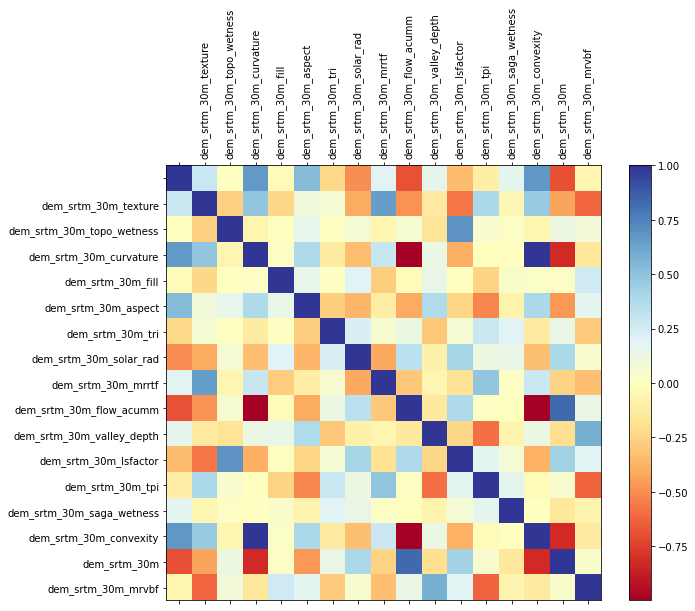

In [39]:
# generate the matrix. < 0.6 weak collinearity, 0.6-0.8 moderate, >= 0.8 strong
nicher.generate_correlation_matrix(df_records=df_pres_abse_data,
                                   show_fig=True,
                                   show_text=False)

### Generate Variance Inflation Factor (VIF) Score

In [ ]:
# generate the matrix
# rule of thumb: 1 = No multicolinearity, 1-5 = moderate, > 5 = high, > 10 = Remove from model
gdvsdm.generate_vif_scores(df_pres_abse_data, rast_cate_list)

## Perform Species Distribution Modelling 

### Create estimator

In [ ]:
# create a random forest estimator using default sklearn parameters
estimator = gdvsdm.create_estimator(estimator_type='rf', n_estimators=500)

### Generate SDM

In [ ]:
# generate SDM with 5 replicates and 10% training-testing split
ds_sdm = gdvsdm.generate_sdm(ds, df_pres_abse_data, estimator, rast_cont_list, rast_cate_list, replicates=5, 
                             test_ratio=0.1, equalise_test_set=False, calc_accuracy_stats=True)

### Display SDM result

In [ ]:
# set the sdm variable to display (i.e. sdm_mean, sdm_stdv, sdm_cvar)
metric_name = 'sdm_mean'

# create fig
fig = plt.figure(figsize=(9, 7), dpi=85)

# plot this on map
ds_sdm[metric_name].plot(robust=False, cmap='jet')

In [ ]:
da = ds_sdm[metric_name]

In [ ]:
ds_sdm.to_netcdf('yandi_sdm.nc')

In [ ]:
# import
from datacube.utils.cog import write_cog

# out crs
crs = 'EPSG:3577'
   
# write tif
write_cog(geo_im=da,
          fname='yandi_sdm_mean.tif',
          crs=crs,
          nodata=-9999,
          overwrite=True)
        

## Temporary dem retriever

### Set up a dask cluster

In [ ]:
# initialise the cluster. paste url into dask panel for more info.
create_local_dask_cluster()

In [ ]:
# open up a datacube connection
dc = datacube.Datacube(app='gdvsdm')

## Study area and data setup

### Set study area

In [ ]:
# set lat, lon (y, x) dictionary of testing areas for gdv project
loc_dict = {
    'test_a':   (-23.28043, 119.85931),
    'test_b':   (-31.60693, 116.94264),
    'test_c':   (-22.64623, 120.16237),
    'test_d':   (-22.74596, 119.10474),
}

# set buffer length and height (x, y)
buff_dict = {
    'test_a': (0.5, 0.5),
    'test_b': (0.5, 0.5),
    'test_c': (0.5, 0.5),
    'test_d': (0.25, 0.1),
}

In [ ]:
# select location from dict
study_area = 'test_d'

# set buffer size in lon, lat (x, y)
lon_buff, lat_buff = buff_dict[study_area][0], buff_dict[study_area][1]

In [ ]:
# select a study area from existing dict
lat, lon = loc_dict[study_area][0], loc_dict[study_area][1]

# combine centroid with buffer to form study boundary
lat_extent = (lat - lat_buff, lat + lat_buff)
lon_extent = (lon - lon_buff, lon + lon_buff)

# display onto interacrive map
display_map(x=lon_extent, y=lat_extent)

### Load SRTM Digital Elevation Model (Resampled to 30m)

In [ ]:
# create query from above and expected info
query = {
    'x': lon_extent,
    'y': lat_extent,
    'measurements': ['dem'],
    'output_crs': 'EPSG:3577',
    'resolution': (80, 80),
    'group_by': 'solar_day',
}


# load srtm dem dataset # multi_scale_topographic_position
ds_dem = dc.load(product='ga_srtm_dem1sv1_0', **query)

# display dataset
#print(ds_dem)

# plot
#ds_dem['dem'].plot(robust=True, cmap='terrain_r')

In [ ]:
# drop time dimension and squeeze out time coordinate
ds_dem = ds_dem.drop('time', errors='ignore')
ds_dem = ds_dem.squeeze('time', drop=True)
#ds_dem['dem'] = ds_dem['dem'].astype('int32')

In [ ]:
# Load raster and reproject to match satellite dataset
raster_path = './dem_80m.tif'
raster_reprojected = rio_slurp_xarray(raster_path,
                                      ds_10m.geobox,
                                      resampling="bilinear")

# Set nodata to `NaN`
raster_reprojected = mask_invalid_data(raster_reprojected)

In [ ]:
ds_10m

In [ ]:
ds_10m['dem'] = raster_reprojected.astype('int16')

In [ ]:
from odc.algo import xr_reproject

In [ ]:
ds_dem['dem'].attrs.get('nodata') = -9999

In [ ]:
at = ds_dem['dem'].attrs
at['nodata'] = -9999
ds_dem['dem'].attrs = at

# import
from datacube.utils.cog import write_cog

# out crs
crs = 'EPSG:3577'
   
# write tif
write_cog(geo_im=ds_dem['dem'].astype('int16'),
          fname='yandi_srtm_dem_30m.tif',
          crs=crs,
          overwrite=True)
        